# Load Modules

In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print("file_dir: -> ",file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

file_dir: ->  C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [3]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (
    #boxplot_histogram,
    clean_up_categoricals
    )

from pa_lib.vis import(
    boxplot_histogram,
    )

from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx
    )
from pa_lib.util import (
    cap_words
    
    )                     

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 300


In [5]:
from pa_lib.data import desc_col

In [7]:
## Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job

################################################################################
## Recursive Dependency Check:
request_job(
    job_name="bd_prepare.py",
    current= "Today" # output: bd_data.feather
    )

14:05:51 [INFO] [ipykernel_launcher.py] requests 'bd_prepare.py'
14:05:51 [INFO] [ipykernel_launcher.py]: Not running job 'bd_prepare.py': result is current ('Today') from 2019-11-27 14:04:14.995058.


# Load Datasets

In [8]:
def load_ek_list_rscript(file):
    raw_text            = open("C:\\Users\stc\data\\vkprog\\predictions\\"+file,"r")
    text_row_list       = raw_text.readlines()
    
    text_single_entries = [x.replace("\n","").split(';') for x in text_row_list]
    
    subselect_list      = [x[0:18] + x[-57:] for x in text_single_entries]
    
    pred_rscript_raw    = pd.DataFrame(data    = subselect_list[1:],
                                       columns = subselect_list[0]
                                      )
    
    prob_col   = [col for col in pred_rscript_raw.columns if col.startswith("prob_KW")]
    col_select = ["ENDKUNDE_NR","Endkunde"] + prob_col
    
    row_select = ((pred_rscript_raw
                      .loc[:,"ENDKUNDE_NR"]
                      .map(lambda x: str(x).isdigit())
                 ) &
                  (pred_rscript_raw
                      .loc[:,prob_col[0]]
                      .map(lambda x: str(x).replace('.','').isdigit())
                 )
                  
                 )
    
    ek_list_rscript = (pred_rscript_raw
            .loc[row_select,col_select]
            .rename(columns={"ENDKUNDE_NR": "Endkunde_NR",
                            prob_col[0]: "Prob_rscript"})
            .astype({"Endkunde_NR": "int64",
                    "Prob_rscript": "float64"})
           )
    
    print(ek_list_rscript.shape)
    
    return ek_list_rscript

In [9]:
# Rebuild predictions:

with project_dir("vkprog\\predictions"):
    #pred_rebuild_df = load_bin("20190701_pred_rebuild.feather")
    pred_rebuild_df = load_bin("20190701_pred_rebuild_without_sales_filter.feather")

####

# Saved R-Script Predictions:
pred_rscript_df_raw = load_ek_list_rscript("20190701_EK_LIST_2W_KOMPLETT.csv")

####

# Raw booking data  (viewpoint today) and list of current VKbers
with project_dir("vkprog"):
    
    # Booking data:
    bd_raw = (
        load_bin("bd_data.feather")
            .rename(
                mapper=lambda name: cap_words(name, sep="_"), axis="columns"
                )
        )
    
    bd = (
        bd_raw
            .loc[(bd_raw.Netto > 0)]
            .pipe(clean_up_categoricals)
        )
    
    del bd_raw # not needed anymore
    
    # List of active Vkber:
    vkprog_raw = load_csv("vkber_data.csv")

14:05:53 [INFO] Started loading binary file ...
14:05:53 [INFO] Reading from file C:\Users\stc\data\vkprog\predictions\20190701_pred_rebuild_without_sales_filter.feather
14:05:53 [INFO] ... finished loading binary file in 0.04s (0.03s CPU)
(11675, 3)
14:05:53 [INFO] Started loading binary file ...
14:05:53 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
14:05:54 [INFO] ... finished loading binary file in 0.15s (0.89s CPU)
14:05:55 [INFO] Started loading CSV ...
14:05:55 [INFO] Reading from file C:\Users\stc\data\vkprog\vkber_data.csv
14:05:55 [INFO] ... finished loading CSV in 0.0s (0.0s CPU)


## DWH Data (actual reservations)

In [10]:
def customer_netto(KW_2, year):
    row_select = (
        # No cancellations/ Annulationen:
        (bd.loc[:,"Kampagnen_Status"] != 3)    &
        
        # Which two week period:
        (bd.loc[:,"Kamp_Erfass_KW_2"] == KW_2) &
        
        # Which year:
        (bd.loc[:,"Kamp_Erfass_Jahr"] == year) &
        
        # Only profitable campaigns:
        (bd.loc[:,"Netto"] >0)
        )

    reality_df = (bd
        .loc[row_select,:]
        .groupby(["Endkunde_NR","Kamp_Erfass_Jahr","Kamp_Erfass_KW_2"])
        .agg({"Netto": np.nansum})
        .reset_index(inplace=False)
        )
    print(f"(year = {year}, KW_2 = {KW_2}), {reality_df.shape}")
    return reality_df

In [11]:
reality_2019_df = customer_netto(KW_2=27,year=2019)
reality_2018_df = customer_netto(KW_2=27,year=2018)

(year = 2019, KW_2 = 27), (619, 4)
(year = 2018, KW_2 = 27), (395, 4)


In [80]:
netto_sum_2018 = reality_2018_df.loc[:,"Netto"].sum()

print(80*"#")
print("Stats from 2018, KW_2 == 45 :\n")
print(f" Tot-Num of Campaigns (Reservations): {reality_2018_df.shape[0]}")
print(f" Tot-Netto-Sum of Reservations:       {netto_sum_2018}")
print(80*"#")

netto_sum_2019 = reality_2019_df.loc[:,"Netto"].sum()
print("Stats from 2019, KW_2 == 45 :\n")
print(f" Tot-Num of Campaigns (Reservations): {reality_2019_df.shape[0]}")
print(f" Tot-Netto-Sum of Reservations:       {netto_sum_2019}")
print(80*"#")

################################################################################
Stats from 2018, KW_2 == 45 :

 Tot-Num of Campaigns (Reservations): 395
 Tot-Netto-Sum of Reservations:       8890023
################################################################################
Stats from 2019, KW_2 == 45 :

 Tot-Num of Campaigns (Reservations): 619
 Tot-Netto-Sum of Reservations:       7894858
################################################################################


# Combine Datasets

In [18]:
desc_col(
    pred_rscript_df_raw,
    det=True,
)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Endkunde_NR,int64,0/11675,11675,182.4 KB,"[100034,656801]"
Endkunde,object,0/11675,11191,1.1 MB,"[,Österreich Werbung Deutschland GmbH]"
Prob_rscript,float64,0/11675,312,182.4 KB,"[0.0,99.8]"


In [74]:
comparision_df = (
    reality_2019_df # Actual reservations
        #
        .merge(
            pred_rscript_df_raw # Predictions, Rscript
            .eval("Prob_rscript = Prob_rscript*0.01")
            .loc[:,["Endkunde_NR","Prob_rscript"]],
            on="Endkunde_NR",
            how="right" 
        )
        .merge(
            pred_rebuild_df # Predictions, Random Forest
            .loc[:,["Endkunde_NR","Prob_1"]],
            on="Endkunde_NR",
            how="inner"
        )
        .fillna(
            value={
                "Kamp_Erfass_Jahr": (reality_2019_df
                                     .loc[:,"Kamp_Erfass_Jahr"]
                                     .max()),
                "Kamp_Erfass_KW_2": (reality_2019_df
                                     .loc[:,"Kamp_Erfass_KW_2"]
                                     .min()),
                "Netto": 0,
                "Prob_rscript": 0,
            
            }
        )
)

In [79]:
print(80*"#")
print("Sample:")
display(
    comparision_df.sample(5)
)

print(80*"#")
print("desc_col:")
display(
    desc_col(
        comparision_df,
        det=True
    )
)

print(80*"#")
print("describe:")
display(
    comparision_df.describe()
)
print(80*"#")

################################################################################
Sample:


,Endkunde_NR,Kamp_Erfass_Jahr,Kamp_Erfass_KW_2,Netto,Prob_rscript,Prob_1
2490,102036,2019,27,0.0,0.030,0.199446
11350,467456,2019,27,0.0,0.003,0.378064
5037,649055,2019,27,0.0,0.020,0.143442
2724,138912,2019,27,0.0,0.029,0.419950
9034,582964,2019,27,0.0,0.009,0.235425


################################################################################
desc_col:


,DTYPE,NULLS,UNIQUE,MEM,RANGE
Endkunde_NR,int64,0/11671,11671,182.4 KB,"[100034,656801]"
Kamp_Erfass_Jahr,category,0/11671,1,103.3 KB,"[2019,2019]"
Kamp_Erfass_KW_2,category,0/11671,1,104.0 KB,"[27,27]"
Netto,float64,0/11671,311,182.4 KB,"[0.0,532605.0]"
Prob_rscript,float64,0/11671,312,182.4 KB,"[0.0,0.998]"
Prob_1,float64,0/11671,11631,182.4 KB,"[0.019811351718893814,0.824726417799398]"


################################################################################
describe:


,Endkunde_NR,Netto,Prob_rscript,Prob_1
count,11671.000000,11671.000000,11671.000000,11671.000000
mean,491520.395339,549.368435,0.027946,0.226705
std,190940.060255,8582.737767,0.057594,0.138717
min,100034.000000,0.000000,0.000000,0.019811
25%,474437.500000,0.000000,0.010000,0.111536
50%,582970.000000,0.000000,0.017000,0.198564
75%,625390.000000,0.000000,0.027000,0.324895
max,656801.000000,532605.000000,0.998000,0.824726


################################################################################


################################################################################

R-Script:


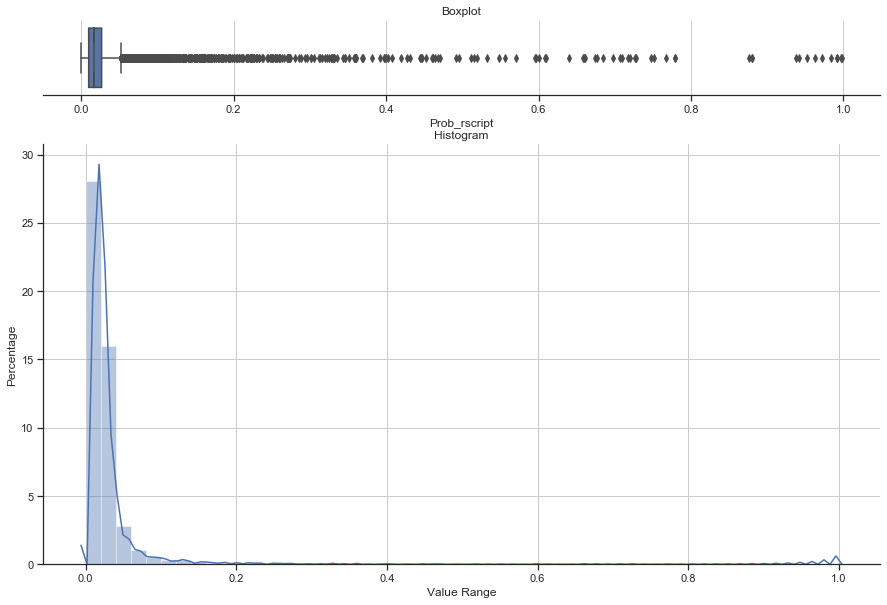

################################################################################

Random Forest:


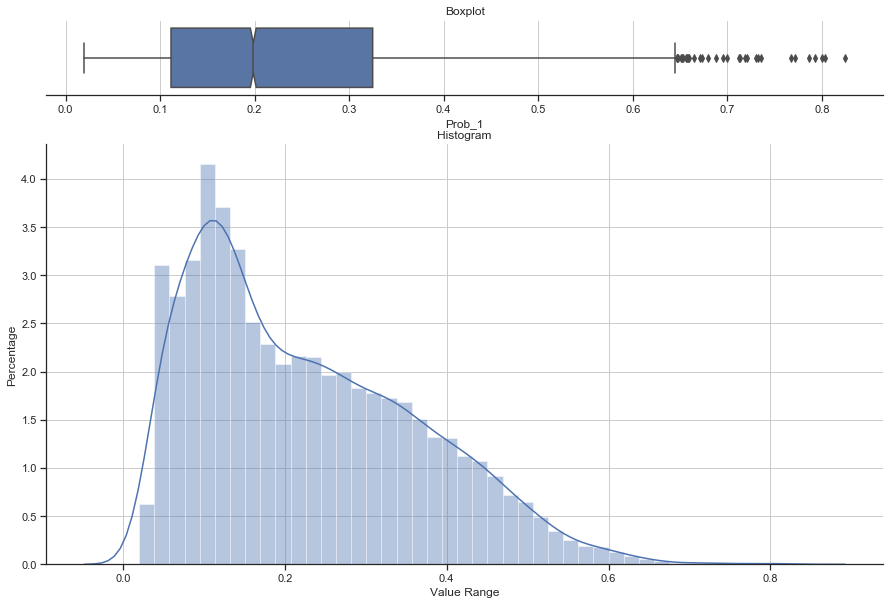

In [31]:
print("#"*80+"\n")
print("R-Script:")
boxplot_histogram(
    comparision_df
        .loc[:,"Prob_rscript"]
)
print("#"*80+"\n")
print("Random Forest:")
boxplot_histogram(
    comparision_df
        .loc[:,"Prob_1"]
)

# Performance based on Cutoff

In [40]:
import matplotlib.pyplot as plt

In [36]:
cutoffs = pd.Series(np.arange(0,1,0.001))
display(cutoffs.head(5))

0    0.000
1    0.001
2    0.002
3    0.003
4    0.004
dtype: float64

In [37]:
def success_sum(cutoff,model):
    row_select = (comparision_df.loc[:,model] >= cutoff)
    
    return comparision_df.loc[row_select,"Netto"].sum()
    

In [38]:
rebuild_series = cutoffs.map(lambda x: success_sum(x,model="Prob_1"))
rscript_series = cutoffs.map(lambda x: success_sum(x,model="Prob_rscript"))

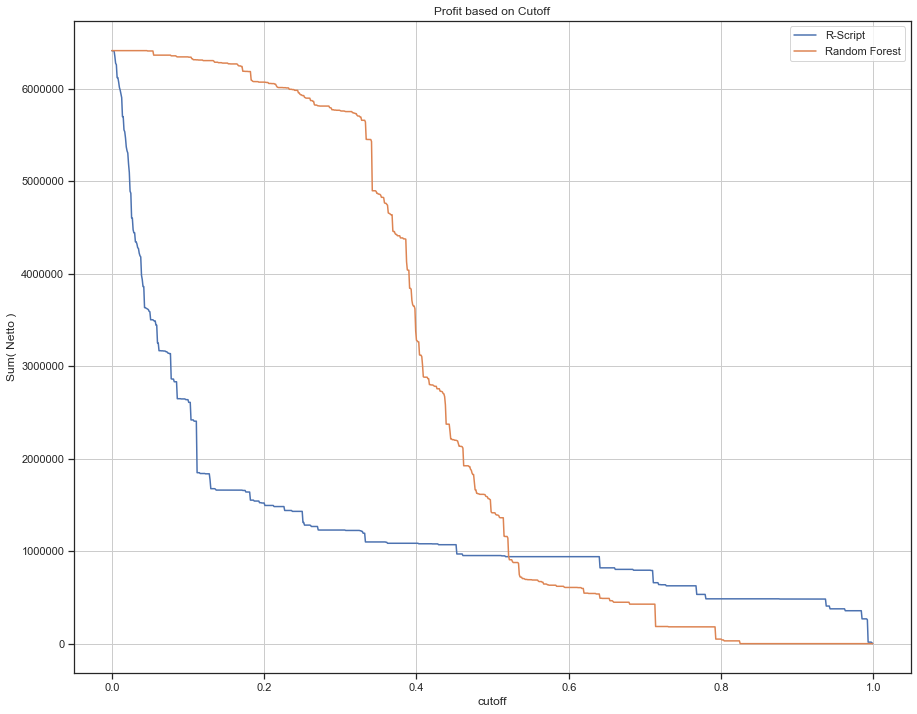

In [41]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(
    cutoffs,
    rscript_series,
    label="R-Script"
)

ax.plot(
    cutoffs,
    rebuild_series,
    label="Random Forest"
)

ax.set(
    xlabel='cutoff',
    ylabel='Sum( Netto )',
    title='Profit based on Cutoff'
)

ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

In [46]:
total = (
    comparision_df
        .loc[:,"Netto"]
        .sum()
)

print(f"AUC, rscript: {np.sum(0.001*rscript_series)/total}"[:19])
print(f"AUC, rebuild: {np.sum(0.001*rebuild_series)/total}"[:19])

AUC, rscript: 0.195
AUC, rebuild: 0.426


# Performance: Cummulative Netto Sum based on Number of selected customers

In [47]:
rscript_cumsum_series = (
    comparision_df
    .sort_values("Prob_rscript",ascending=False)
    .loc[:,"Netto"]
    .cumsum()
)


rebuild_cumsum_series = (
    comparision_df
    .sort_values("Prob_1",ascending=False)
    .loc[:,"Netto"]
    .cumsum()
)

In [49]:
#rscript_cumsum_series
#rebuild_cumsum_series
number_contacts = pd.Series(
    np.arange(1, len(rscript_cumsum_series)+1, 1)
)

In [50]:
comparision_df.shape

(11671, 6)

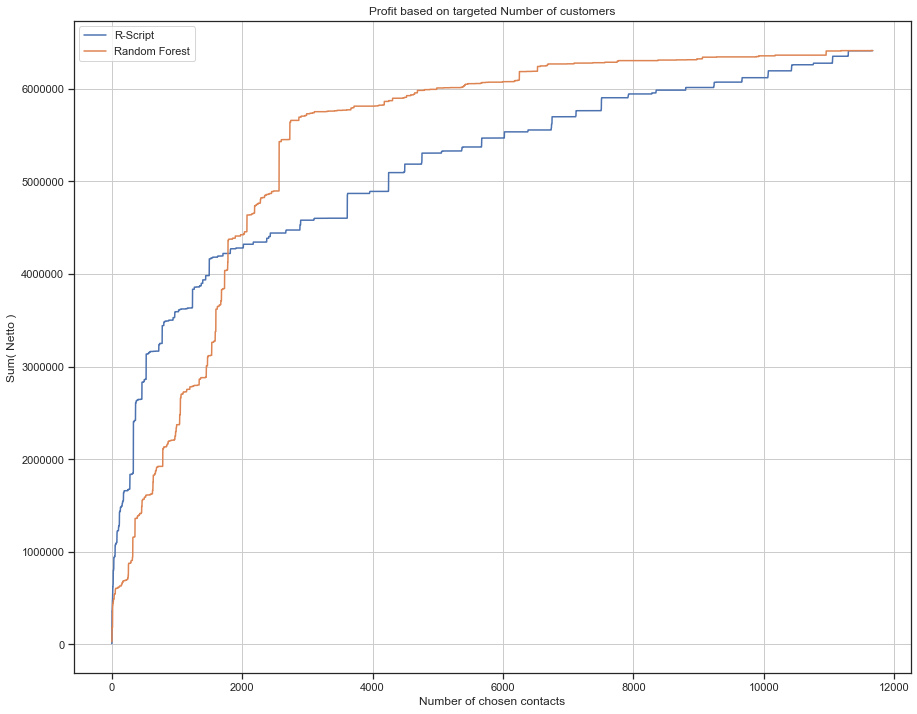

In [51]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(number_contacts, rscript_cumsum_series,label="R-Script")
ax.plot(number_contacts, rebuild_cumsum_series,label="Random Forest")

ax.set(xlabel='Number of chosen contacts', ylabel='Sum( Netto )',
       title='Profit based on targeted Number of customers')
ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

In [52]:
number_rscript = (
    comparision_df
        .sort_values("Prob_rscript",ascending=False)
        .loc[:,"Netto"]
        .map(lambda x: int(bool(x)))
        .cumsum()
        .reset_index(inplace=False)
        .loc[:,"Netto"]
    )

In [53]:
number_rebuild = (
    comparision_df
        .sort_values("Prob_1",ascending=False)
        .loc[:,"Netto"]
        .map(lambda x: int(bool(x)))
        .cumsum()
        .reset_index(inplace=False)
        .loc[:,"Netto"]
    )

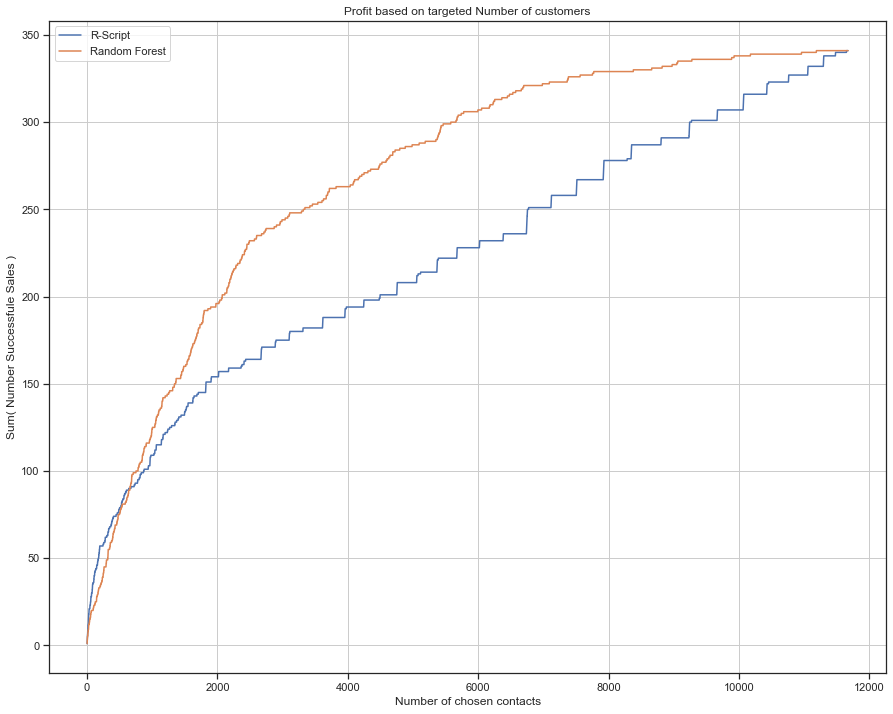

In [54]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(
    number_contacts,
    number_rscript,
    label="R-Script"
)

ax.plot(
    number_contacts,
    number_rebuild,
    label="Random Forest"
)

ax.set(
    xlabel = 'Number of chosen contacts',
    ylabel = 'Sum( Number Successfule Sales )',
    title  = 'Profit based on targeted Number of customers'
)

ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

In [55]:
len(number_contacts)

11671

In [56]:
print("AUC (percentage):")
print(f"Rebuild:  {number_rebuild.sum() / (number_rscript.max()*number_contacts.max() - number_rscript.max()**2/2 )}"[:15])
print(f"R-Script: {number_rscript.sum() / (number_rscript.max()*number_contacts.max() - number_rscript.max()**2/2 )}"[:15])



AUC (percentage):
Rebuild:  0.805
R-Script: 0.665


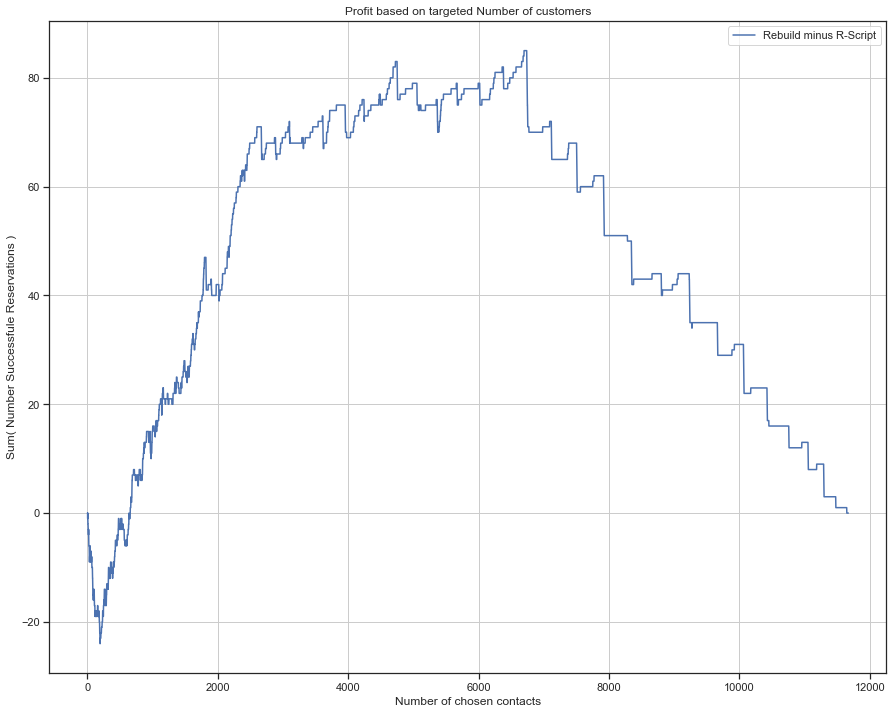

In [58]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(
    number_contacts,
    number_rebuild-number_rscript,
    label="Rebuild minus R-Script"
)


ax.set(
    xlabel='Number of chosen contacts',
    ylabel='Sum( Number Successfule Reservations )',
    title='Profit based on targeted Number of customers'
)

ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

***
- It's rather unlikely to contact 6000 customers.
- It has to be taken into respect of how many active VKbers are employed, and deduce from this a feasible number of customers

***

## Number of Vkbers

In [59]:
vkprog_raw.head(3)

,MA_ID,KOMBI_NAME,E_MAIL,KURZZEICHEN,FUNKTION,KAM
0,125,Schnyder Bernhard,bernhard.schnyder@apgsga.ch,ABS,Key Account Management,True
1,15505,Coralic Alma,alma.coralic@apgsga.ch,ACO,Verkaufsberatung Ost Aussendienst,False
2,155,Steltzlen Andreas,andreas.steltzlen@apgsga.ch,AST,Leitung Verkaufsberatung Bern Mitte,False


################################################################################
# Tot-Num of Vkbers:          89
# Max-Num of Leads per Vkber: 20
# Max-Num of Leads in Total:  1780
################################################################################


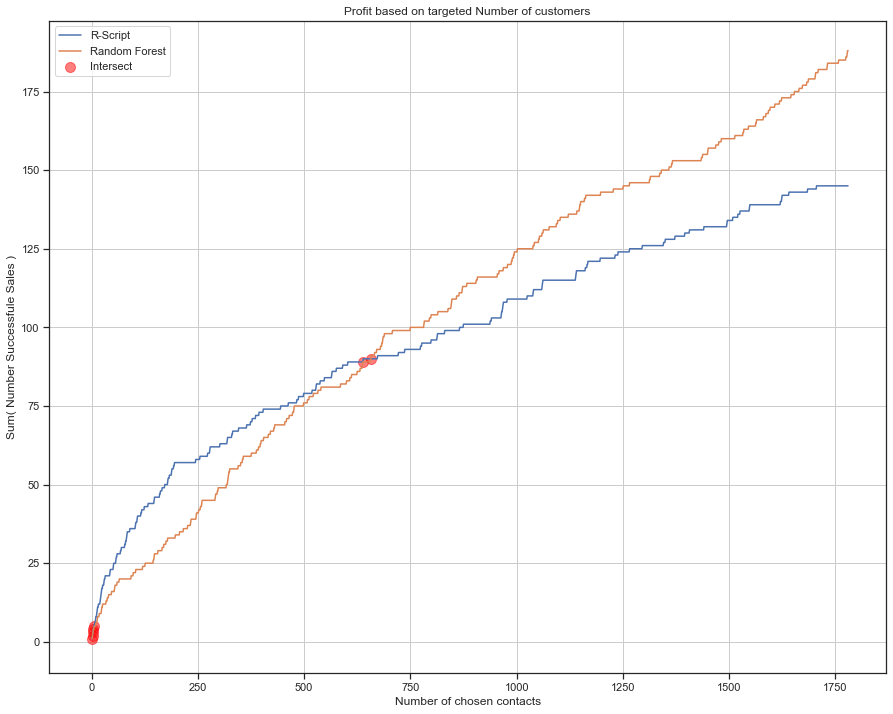

In [102]:
num_vkbers = len(set(vkprog_raw.loc[:,"KURZZEICHEN"]))
per_vkber  = 20 # Average number of contact that should be given to a VKber
total_max_num = num_vkbers*per_vkber

print(80*"#")
print(f"# Tot-Num of Vkbers:          {num_vkbers}")
print(f"# Max-Num of Leads per Vkber: {per_vkber}")
print(f"# Max-Num of Leads in Total:  {total_max_num}")
print(80*"#")

equals_df = pd.DataFrame(
    {"Contacts": (
        pd.Series(
            number_rscript[(number_rebuild == number_rscript)].index + 1
        )
    ),
    
     "Numbers": list(number_rscript[(number_rebuild == number_rscript)])}
)

row_select = (equals_df.loc[:,"Contacts"] < total_max_num)



fig, ax = plt.subplots(figsize=(15,12))


ax.plot(number_contacts[:total_max_num],
        number_rscript[:total_max_num],
        label="R-Script"
       )

ax.plot(number_contacts[:total_max_num],
        number_rebuild[:total_max_num],
        label="Random Forest"
       )

ax.scatter(
    equals_df.loc[row_select,"Contacts"],
    equals_df.loc[row_select,"Numbers"],
    marker = "o",
    s      = 100, # size
    c      = "red", # color
    alpha  = 0.5,
    label  = "Intersect",
)

ax.set(xlabel='Number of chosen contacts',
       ylabel='Sum( Number Successfule Sales )',
       title='Profit based on targeted Number of customers')
ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

In [104]:
print("Intersect/Tipping points:")

display(
    equals_df
        .loc[row_select,:]
        .rename(
            columns={"Contacts": "Number_of_Contacts",
                     "Numbers":"Number_of_Sales"}
        )
)

Intersect/Tipping points:


,Number_of_Contacts,Number_of_Sales
0,1,1
1,2,2
2,3,3
3,4,4
4,6,5
5,638,89
6,657,90


# Sandbox